In [1]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import sys
import pandas as pd
from scipy.signal import savgol_filter,resample
from sklearn.decomposition import PCA
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error as mse
from importlib import reload
import scipy.io
import matplotlib.cm as cm
import pickle
import matplotlib as mpl
import shutil
import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
# import tensorflow as tf
# print(tf.__version__)
import time
#from tensorflow import keras
#from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten,BatchNormalization,Input
#from tensorflow.keras.models import load_model, Model,Sequential
#from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, CSVLogger,ReduceLROnPlateau
#gpus = tf.config.experimental.list_physical_devices('GPU') 
from sklearn.metrics import r2_score, mean_squared_error
# if gpus:
#     try:
#         for gpu in gpus:
#             limit =  8192# 10G memory per GPU
#             tf.config.experimental.set_virtual_device_configuration(
#                 gpu,
#                 [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=limit)]
#             )
#         tf.config.set_visible_devices(gpus[0], 'GPU')
#     except RuntimeError as e:
#         # Virtual devices must be set before GPUs have been initialized
#         print(e)

In [2]:
plt.rcParams["font.size"]=17
plt.rcParams["pdf.use14corefonts"] = True
plt.rcParams["ps.useafm"] = True
plt.rcParams["font.family"]='sans-serif'

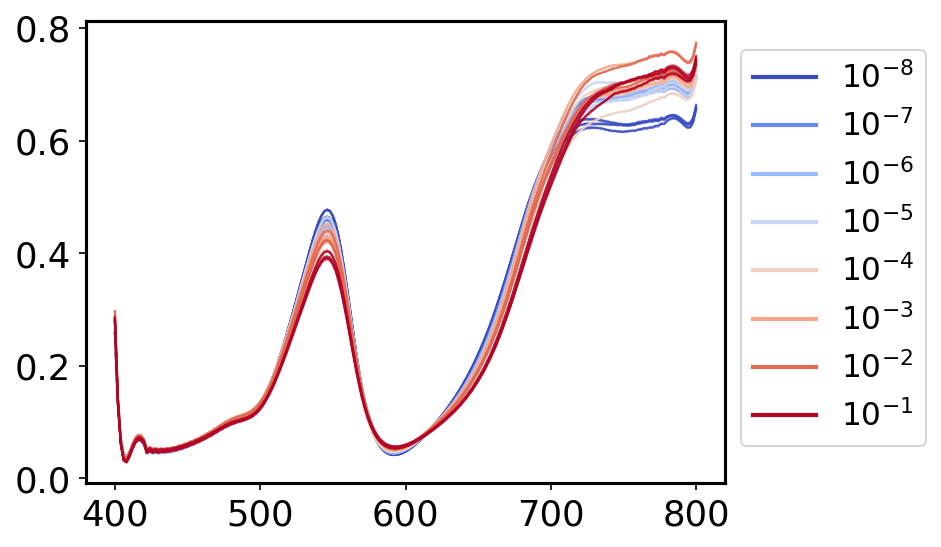

In [3]:
test_split_method = 'batch'
remove_concentration= [0,-12,-13]
data_dir = './data/dopamine_pbs/'
wls = np.loadtxt(data_dir+'wavelengths.txt')
X_an = np.load(data_dir+'X_raw.npy')
X_an = resample(X_an,201,axis=2)/200
X_an = savgol_filter(X_an,21,5)
df = pd.read_csv(data_dir+'labels.csv')
df['status'] = 'train'
if test_split_method == 'batch':
    for concentration in df['concentration'].unique():
        # Get unique batches for this concentration
        batches = df[df['concentration'] == concentration]['batch'].unique()
        # Randomly select 1/4 of these batches for the test set, minimum 1
        test_batches = np.random.choice(batches, max(1, len(batches) // 4), replace=False)
        # Label the selected batches as 'test'
        df.loc[(df['concentration'] == concentration) & (df['batch'].isin(test_batches)), 'status'] = 'test'
elif test_split_method== 'sample':
    # Randomly select 1/4 of the samples for the test set, minimum 1
    test_samples = np.random.choice(df.index, max(1, len(df) // 5), replace=False)
    df.loc[df.index.isin(test_samples), 'status'] = 'test'
df = df[~df['concentration'].isin(remove_concentration)]
X_an = X_an.reshape(-1,201)[df.index]
X_an = X_an.reshape(-1,30,201)
c_list = np.unique(df.concentration)
colors = cm.coolwarm(np.linspace(0, 1, len(c_list)))
plt.figure(figsize=(5.5,4),dpi=150)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
for c in range(len(X_an)):
    legend_flag = 1
    for b in np.arange(0,9):
        if legend_flag:
            label = r'$10^{' + str(c_list[c]+3) +r'}$'
            plt.plot(wls,X_an[c,b],color=colors[c],alpha=0.6,linewidth=1,label=label)
            legend_flag = 0
        else:
            plt.plot(wls,X_an[c,b],color=colors[c],alpha=0.6,linewidth=1)
legend=plt.legend(fontsize=15,loc='center left', bbox_to_anchor=(1, 0.51),)
for li in range(8):
    legend.get_lines()[li].set_linewidth(2)
    legend.get_lines()[li].set_alpha(1)

#plt.xlabel('wavelegnth (nm)')
#plt.ylabel('normalized intensity')

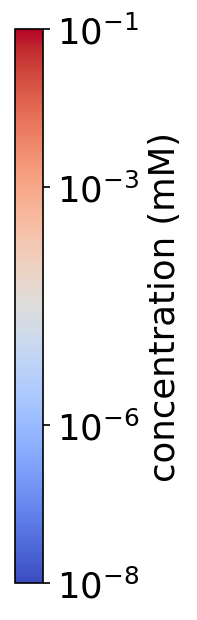

In [7]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(dpi=150)

plt.imshow(np.array([[0, 1]]), cmap='coolwarm')
plt.gca().set_visible(False)

cbar = plt.colorbar()
cbar.set_label(r'concentration (mM)', fontsize=17)
cbar.set_ticks([0, 2/7, 5/7,1])
cbar.set_ticklabels([r'$10^{-8}$', r'$10^{-6}$', r'$10^{-3}$',r'$10^{-1}$'])

plt.show()


In [76]:
X = X_an.reshape(len(c_list)*9,-1)
Y = np.array(df.concentration)
Y_reg = (Y-Y.min()) / (Y.max()-Y.min())

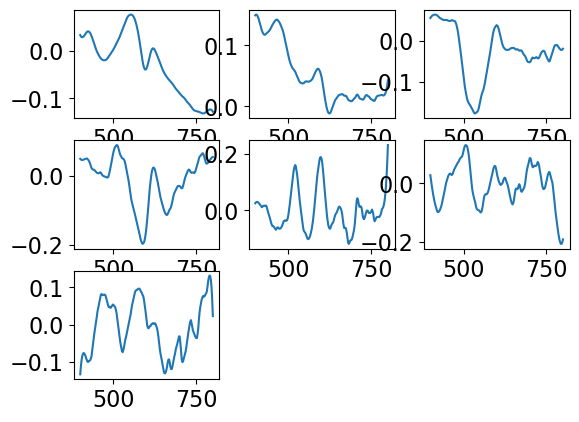

In [79]:
pca = PCA(n_components=8, svd_solver='full')
pc=pca.fit_transform(X)
pca_components = pca.components_
for i in range(7):
    plt.subplot(3,3,i+1)
    plt.plot(wls,pca_components[i])
#np.save(data_dir+'pca4.npy',pca_components)

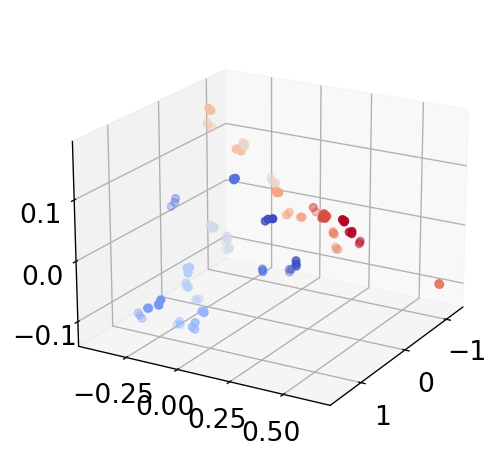

In [179]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# assuming 'pc' is a numpy array with your PCA results, shape (108, 8)
# and 'y' is a numpy array with your labels, shape (108,)
y=Y.copy()
fig = plt.figure(dpi=120)
ax = fig.add_subplot(111, projection='3d')
# Creating a color map for the labels
unique_labels = np.unique(y)
colors = plt.cm.get_cmap('coolwarm', len(unique_labels))

for i, label in enumerate(unique_labels):
    subset = pc[y == label]
    ax.scatter(subset[:, 0], subset[:, 1], subset[:, 2], color=colors(i), label=str(label))

#ax.set_xlabel('PC1')
#ax.set_ylabel('PC2')
#ax.set_zlabel('PC3')
#plt.legend()
ax.view_init(elev=20, azim=30)

plt.show()


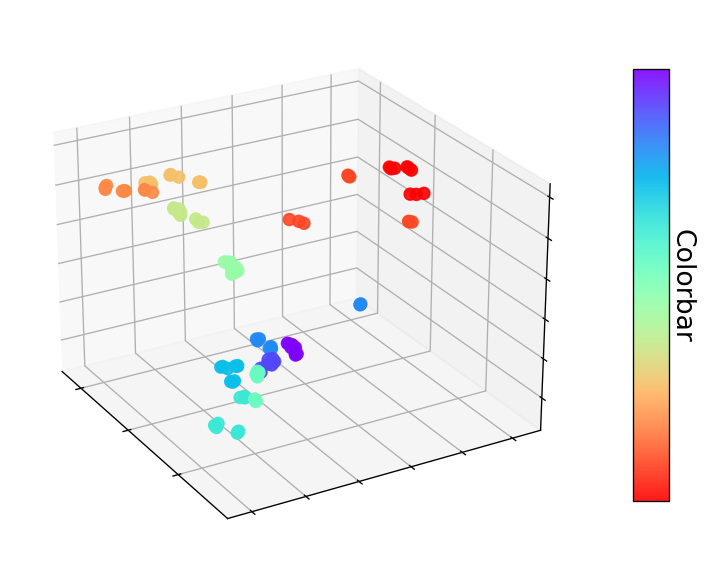

In [175]:
colors = cm.rainbow_r(np.linspace(0, 1, 12))

from mpl_toolkits.mplot3d import Axes3D
fig=plt.figure(figsize=(6,6),dpi=120)
ax = fig.add_subplot(projection='3d')
ax.set_facecolor('w')
#x.scatter(x, y, c=c, cmap=cm.rainbow_r)
scat=ax.scatter(pc[:,2],pc[:,1],pc[:,0],c=(Y-9).astype(np.int32),alpha=0.9,s=50,cmap=cm.rainbow_r)
ax.view_init(elev=25, azim=-30)
#ax.grid(color='r', linestyle='.', linewidth=2)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.set_zticklabels([])
#ax.set_xlabel('1st PC')
#ax.set_ylabel('2nd PC')

cbar=plt.colorbar(scat ,cax=fig.add_axes([0.99, 0.2, 0.05, 0.6]),ticks=[])
#cbar.ax.set_ylabel('Colorbar', rotation=270, labelpad=15)

#ax.set_zlabel('3rd PC')
plt.show()